In [4]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
import time

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#Useful functions

def import_matfiles(path):
    list_mat_ex = os.listdir(path2)
    #list_mat_file contains all interessant files for our research
    list_mat_ex.remove('readme.txt')
    #list_mat_file contains all interessant files for our research
    label = list_mat_ex[-1]
    print(label)
    list_mat_ex.pop(-1)
    return list_mat_ex, label
    
def find_max_shape(datas, freq = None):
    #shape of data in datas (freq, nb channel, activity)
    if freq == None:
        max_ = datas[0].shape[2]
        for data in datas[1:]:
            act_shape = data.shape[2]
            if act_shape > max_ :
                max_ = act_shape
    else :
        #hape of data in datas (nb channel, activity)
        max_ = datas[0].shape[1]
        for data in datas[1:]:
            act_shape = data.shape[1]
            if act_shape > max_ :
                max_ = act_shape
    return max_  

def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x).type(torch.float32)

def datas_shaper(datas):
    res = []
    for data in datas:
        print(data.shape)
        res.append(x_shaper(data))
    return res 

def padd(datas, freq = None):
    #shape of data in datas (freq, nb channel activity)
    max_shape = find_max_shape(datas, freq =freq)
    res = []
    if freq == None :
        for data in datas:
            aux = torch.zeros((data.shape[0], data.shape[1], max_shape))
            if data.shape[2] < max_shape:
                add_shape = max_shape - data.shape[2]
                for freq in range(data.shape[0]):
                    pad_tensor = torch.zeros((data.shape[1], add_shape))
                    aux[freq, :, :] = torch.cat((data[freq, :, :], pad_tensor), dim=1)
                    aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    else :
        for data in datas:
            aux = torch.zeros((data.shape[0], max_shape))
            if data.shape[1] < max_shape:
                add_shape = max_shape - data.shape[1]
                pad_tensor = torch.zeros((data.shape[0], add_shape))
                aux = torch.cat((data, pad_tensor), dim=1)
                aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    return res

def normalize(x, freq = None):
    if freq == None:
        for frequencies in range(x.shape[0]):
            mean_ = torch.mean(x[frequencies, :, :], 1).reshape(-1, 1)
            std_ = torch.std(x[frequencies, : ,: ], 1).reshape(-1, 1)
            x[frequencies, :, :] = (x[frequencies, :, :] - mean_) / std_
            return x
    else :
        mean_ = torch.mean(x[freq, :, :], 1).reshape(-1, 1)
        std_ = torch.std(x[freq, : ,: ], 1).reshape(-1, 1)
        x[freq, :, :] = (x[freq, :, :] - mean_) / std_
        return x[freq, :, :]

In [20]:
#version to improve in a near future..
class SignalDataset(Dataset):
    def __init__(self, path, signals, subject_number, experiment_number, labels, smoothing_method, freq = None):
        """
        Args: 
            path: path to folder with all the .mat files of the dataset
            signals: feature that we want to extract
            subject_number: subject of the experimenr
            epxeriment_number: number of the experiment, like 0 week 1 week or 2 week 
            (MAYBE I MISUNDERSTOOD THIS PART READ AGAIN DATASET DETAILS)
            labels: labels list
            smoothing method: movingAve or LDS
            freq: 0, 1, 2, 3 or 4 for just specific one and None if you want them all
        """
        list_file, _ = import_matfiles(path)
        #selection of interesting files that means the one related to the subject
        list_sub_file = []
        for file in list_file:
            num = file.split('_')[0]
            if int(num) == subject_number: 
                list_sub_file.append(file)
             
        working_file = list_sub_file[experiment_number]
        
        dic = loadmat(path + '\\' + working_file) 
        if smoothing_method == 'movingAve':
            smooth = signals.lower() + '_movingAve'
        elif smoothing_method == 'LDS':
            smooth = signals.lower() + '_LDS'
        else :
            raise ValueError('Please select a good smoothing method: movingAve or LDS')
        
        #maybe a list is not the best tool to store it
        datas = []
        for k in range(15):
            sig = dic[smooth + str(k+1)]
            sig = x_shaper(sig)
            sig = normalize(sig, freq = freq) #change the freq if needed!!!!!!!!!!!!
            datas.append(sig)
            
        
        datas = padd(datas, freq = freq) #everything is happening in this function, the changement from Long to Float
                                    #and the slicing for the frequency we want

        labels = labels.reshape(-1, )
        labels = labels + 1 #sliding to use CrossEntropy Pytorch function
        labels = torch.from_numpy(labels)
                                  
                                  
        self.datas = datas
        self.labels = labels
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        return self.datas[idx], self.labels[idx].item()

In [21]:
#get labels 
path2 = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
l, label_ = import_matfiles(path2)
labels = loadmat(path2 + '\\' + label_)['label']

label.mat


In [38]:
path = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
signals = 'de'
subject_number = 10
experiment_number = 2
labels = labels
smoothing_method = 'LDS'
dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method, freq = 0)
train_dataset, test_dataset = random_split(dataset, [9, 6])
print(len(dataset))
print(len(train_dataset), len(test_dataset))

label.mat
15
9 6


In [39]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [40]:
samp = next(iter(train_loader))
data, lab = samp
print(data.dtype)
print(data.shape)
print(lab)

torch.float32
torch.Size([1, 62, 265])
tensor([2])


In [41]:
#creation of the adjency matrix

channel = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 
                'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6','FT8','T7','C5','C3','C1',
                'CZ','C2','C4','C6', 'T8','TP7','CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8','P7',
                'P5','P3','P1','PZ','P2','P4','P6','P8','PO7','PO5','PO3','POZ','PO4','PO6','PO8','CB1',
                'O1','OZ','O2','CB2']
idx = np.arange(62)
df_channel = pd.DataFrame({'idx': idx, 'channel': channel })

#initialization of the adjency matrix
feature_number = 62
W = np.zeros((5, feature_number, feature_number))
for freq in range(5):
    #I don't see other way than initialiazing W manually
    #was done accodingly to the EEG channel map and order, hope to don't have make mistake
    #FP1
    W[freq, 0, 1] = 1
    W[freq, 0, 3] = 1
    #FPZ
    W[freq, 1, 0] = 1
    W[freq, 1, 2] = 1
    #FP2
    W[freq, 2, 1] = 1
    W[freq, 2, 4] = 1
    #AF3
    W[freq, 3, 8] = 1
    W[freq, 3, 7] = 1
    W[freq, 3, 6] = 1
    W[freq, 3, 0] = 1
    #AF4
    W[freq, 4, 2] = 1
    W[freq, 4, 10] = 1
    W[freq, 4, 11] = 1
    W[freq, 4, 12] = 1
    #F7
    W[freq, 5, 6] = 1
    W[freq, 5, 14] = 1
    #F5
    W[freq, 6, 3] = 1
    W[freq, 6, 5] = 1
    W[freq, 6, 15] = 1
    W[freq, 6, 7] = 1
    #F3
    W[freq, 7, 3] = 1
    W[freq, 7, 8] = 1
    W[freq, 7, 16] = 1
    #F1
    W[freq, 8, 9] = 1
    W[freq, 8, 17] = 1
    #FZ
    W[freq, 9, 10] = 1
    W[freq, 9, 18] = 1
    #F2
    W[freq, 10, 11] = 1
    W[freq, 10, 19] = 1
    #F4
    W[freq, 11, 12] = 1
    W[freq, 11, 20] = 1
    #F6 
    W[freq, 12, 13] = 1
    W[freq, 12, 21] = 1
    #F8
    W[freq, 13, 22] = 1
    #FT7
    W[freq, 14, 15] = 1
    W[freq, 14, 23] = 1
    #FC5 to TP8
    for k in range(15, 41): #till TP8 (number 40) we have two new neigbors: on the right and under +1 and +9 (nine electrodes per line)
        if k == 22 or k == 31 or k == 40 :
            W[freq, k, k+9] = 1
        else:
            W[freq, k, k+1] = 1
            W[freq, k, k+9] = 1
    #P7
    W[freq, 41, 42] = 1
    W[freq, 41, 50] = 1
    #P5
    W[freq, 42, 43] = 1
    W[freq, 42, 51] = 1
    #P3
    W[freq, 43, 44] = 1
    #P1
    W[freq, 44, 45] = 1
    W[freq, 44, 52] = 1
    #PZ
    W[freq, 45, 46] = 1
    W[freq, 45, 53] = 1
    #P2
    W[freq, 46, 47] = 1
    W[freq, 46, 54] = 1
    #P4
    W[freq, 47, 48] = 1
    #P6
    W[freq, 48, 49] = 1
    W[freq, 48, 55] = 1
    #P8
    W[freq, 49, 56] = 1
    #PO7
    W[freq, 50, 51] = 1
    W[freq, 50, 57] = 1
    #PO5
    W[freq, 51, 52] = 1
    W[freq, 50, 57] = 1
    #PO3
    W[freq, 52, 53] = 1
    W[freq, 52, 58] = 1
    #POZ
    W[freq, 53, 54] = 1
    W[freq, 53, 59] = 1
    #PO4
    W[freq, 54, 55] = 1
    W[freq, 54, 60] = 1
    #PO6
    W[freq, 55, 56] = 1
    W[freq, 55, 61] = 1
    #PO8
    W[freq, 56, 61] = 1
    #CB1
    W[freq, 57, 58] = 1
    #O1
    W[freq, 58, 59] = 1
    #OZ
    W[freq, 59, 60] = 1
    #O2
    W[freq, 60, 61] = 1

for freq in range(5):
    for i in range(feature_number):
        for j in range(i, feature_number):
            if W[freq, j, i] == 0:
                W[freq, j, i] = W[freq, i, j]
    W[freq, :, :] = W[freq, :, :] - np.eye(feature_number)

#for some training stability reasons we initialized the diagonal of W with 1
for freq in range(5):
    W[freq, :, :] = W[freq, :, :] + np.eye(W.shape[1], dtype=int)
W = torch.from_numpy(W).type(torch.float32)
print(W.shape)
print(W[0])

torch.Size([5, 62, 62])
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])


In [42]:
#functions use inside the model

##### CREATE A CLASS IF IMPLEMENTATION FINISHED ####
#more elegant


def D_matrix(W, multifreq = True):
    if multifreq:
        for freq in range(W.shape[0]):
            D[freq, :, :] = torch.diag(W[freq].sum(dim=-1))
    else :
        D = torch.diag(W.sum(dim=-1))
    return D

def D_square_matrix(W, multifreq = True):
    if multifreq:
        for freq in range(W.shape[0]):
            D_square[freq, :, :] = torch.diag(torch.pow(W[freq, :, :].sum(dim=-1), -0.5))
    else :
        D_square = torch.diag(torch.pow(W.sum(dim=-1), -0.5))
    return D_square

def laplacian(W, multifreq = True): #here we calculate the non noramlized Laplacian matrix of the graph
    #multifreq means if we get the five frequencies in one or not
    L = D_matrix(W, multifreq = multifreq) - W
    L = L.type(torch.float32)
    return L

def laplacian_norm_mod(W, multifreq = False): #we don't include multifreq option for this function
    D_square = D_square_matrix(W, multifreq = multifreq)
    L_norm_mod = torch.matmul(D_square, torch.matmul(W + torch.eye(W.shape[0]), D_square))
    return L_norm_mod


def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x)


def cheby_laplacian(L, x, theta, multifreq = True):
    """
    Arg: Laplacian matrix, x the extracted signal, theta chebyshev coefficients, K the order of the polynom
    
    we suppose that x was transform to a tensor and that its shape was made as (freq, nb channel, activity)
    
    Return: the sum thetak*Tk(L)*x
    """
 
    y = torch.zeros_like(x) 
    K = theta.shape[0] - 1
    
    if multifreq :
        L_tilde = torch.zeros_like(L) 
        for freq in range(L.shape[0]):
            #chebyshev polynoms is a basis in the domain [-1, 1]
            with torch.no_grad():
                eigenvalues, eigenvectors = torch.linalg.eig(L[freq, :, :])
                eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
                max_lambda = torch.max(eigenvalues).item() 
            L_tilde[freq, :, :] = ((2*L[freq, :, :]) / max_lambda) - torch.eye(L.shape[1])
            
            x_ = x[freq, :, :]
            L_ = L_tilde[freq, :, :]
            L_.type(torch.float32)

            x0_hat = x_
            x1_hat = torch.matmul(L_, x_)

            if K == 0:
                y[freq, :, :] = x0_hat*theta[0]
            if K == 1:
                y[freq, :, :] = x1_hat*theta[1] + x0_hat*theta[0]
            else:
                y[freq, :, :] = x0_hat*theta[0] + x1_hat*theta[1] 
                for k in range(2, K):
                    x2_hat = 2*torch.matmul(L_, x1_hat) - x0_hat
                    y[freq, :, :] += x2_hat*theta[k]
                    x1_hat = x2_hat
                    x0_hat = x1_hat
    else :
        with torch.no_grad():
            eigenvalues, eigenvectors = torch.linalg.eig(L)
            eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
            max_lambda = torch.max(eigenvalues).item() 
            
        #rescaling
        L_tilde = ((2*L) / max_lambda) - torch.eye(L.shape[0])
        
        #intialization of variables
        x_ = x
        L_ = L_tilde
        
        L_ = L_.type(torch.float32)

        x0_hat = x_
        x1_hat = torch.matmul(L_, x_)
        
        #calculus of Chebyshev polynoms
        if K == 0:
            y = x0_hat*theta[0]
        elif K == 1:
            y = x1_hat*theta[1] + x0_hat*theta[0]
        else:
            y = x0_hat*theta[0] + x1_hat*theta[1] 
            for k in range(2, K):
                x2_hat = 2*torch.matmul(L_, x1_hat) - x0_hat
                y += x2_hat*theta[k]
                x1_hat = x2_hat
                x0_hat = x1_hat              
    return y

In [43]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class DGCNNormModLayerCheb(nn.Module):
    def __init__(self, W, K):
        super().__init__()
        self.W = nn.Parameter(W)
        self.theta = nn.Parameter(torch.FloatTensor(K, 1))
        self.theta = nn.init.uniform_(self.theta, 0, 10)
        
    def forward(self, x):
        L = laplacian_norm_mod(self.W, multifreq = False)
        X = cheby_laplacian(L, x, self.theta, multifreq = False)
        return X
    
class DGCN_ChebNormMod(nn.Module):
    def __init__(self, W, K, input_size, hidden_size, output_size):
        super().__init__()
        self.DGCNLayer1 = DGCNNormModLayerCheb(W, K)
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.3)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.DGCNLayer1(x) 
        x = F.relu(x)
        x = x.view(-1, self.input_size)
        x = self.l1(x)
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.l2(x)
        return self.tanh(x)

In [62]:
#matrix we will work with
W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

K = 10
#model
model = DGCN_ChebNormMod(W_, K, 62*265, 50, 3).to(device)
print('------------- Model architecture ---------------')
print(model.parameters)
print(' ')
print('------------- Model parameters ---------------')
for param in model.parameters():
    print(type(param.data), param.size())
    
#hyperparameters, loss functions and optimizer

learning_rate = 0.0001
alpha = 1e-7 #regularization parameter
num_epochs = 500

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

------------- Model architecture ---------------
<bound method Module.parameters of DGCN_ChebNormMod(
  (DGCNLayer1): DGCNNormModLayerCheb()
  (l1): Linear(in_features=16430, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)>
 
------------- Model parameters ---------------
<class 'torch.Tensor'> torch.Size([62, 62])
<class 'torch.Tensor'> torch.Size([10, 1])
<class 'torch.Tensor'> torch.Size([50, 16430])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([3, 50])
<class 'torch.Tensor'> torch.Size([3])


In [63]:
#training of the model
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    t1 = time.time()
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()        # Put the network into training mode
    
    for i, (signal, label_) in enumerate(train_loader):
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(signal)      # Do the forward pass
        loss = criterion(outputs, label_) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss

        #L1-Regularization
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + alpha*l1_norm
        loss.backward()           # Calculate the gradients with help of back propagation
       #print('W')
        #print(model.DGCNLayer1.W)
        #print(model.DGCNLayer1.W.grad)
       #print('theta')
       #print(model.GCNLayer1.theta)
       #print(model.GCNLayer1.theta.grad)
        optimizer.step()          # Adjust the parameters based on the gradients
        
        
        # Record the correct predictions for training data 
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == label_).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / float(len(train_dataset))))
   

    ############################
    # Test
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (signal, label_) in enumerate(test_loader):
        
        outputs = model(signal)      # Do the forward pass
        loss += criterion(outputs, label_).item() # Calculate the loss
        
        # Record the correct predictions for training data
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == label_).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone()])[0]
    valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)
    
    t2 = time.time()
    
    if (epoch+1) % 50 == 0:
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
                 valid_loss[-1], valid_accuracy[-1]))

Epoch 50/500, Tr Loss: 0.5652, Tr Acc: 88.8889, Val Loss: 1.0820, Val Acc: 50.0000
Epoch 100/500, Tr Loss: 0.4879, Tr Acc: 88.8889, Val Loss: 1.0870, Val Acc: 50.0000
Epoch 150/500, Tr Loss: 0.4506, Tr Acc: 88.8889, Val Loss: 1.0901, Val Acc: 50.0000
Epoch 200/500, Tr Loss: 0.3930, Tr Acc: 100.0000, Val Loss: 1.0960, Val Acc: 33.3333
Epoch 250/500, Tr Loss: 0.3952, Tr Acc: 100.0000, Val Loss: 1.0967, Val Acc: 33.3333
Epoch 300/500, Tr Loss: 0.3412, Tr Acc: 100.0000, Val Loss: 1.1046, Val Acc: 33.3333
Epoch 350/500, Tr Loss: 0.3352, Tr Acc: 100.0000, Val Loss: 1.1083, Val Acc: 33.3333
Epoch 400/500, Tr Loss: 0.3121, Tr Acc: 100.0000, Val Loss: 1.1115, Val Acc: 33.3333
Epoch 450/500, Tr Loss: 0.3883, Tr Acc: 100.0000, Val Loss: 1.1157, Val Acc: 50.0000
Epoch 500/500, Tr Loss: 0.2854, Tr Acc: 100.0000, Val Loss: 1.1211, Val Acc: 50.0000


In [ ]:
print(t2-t1)

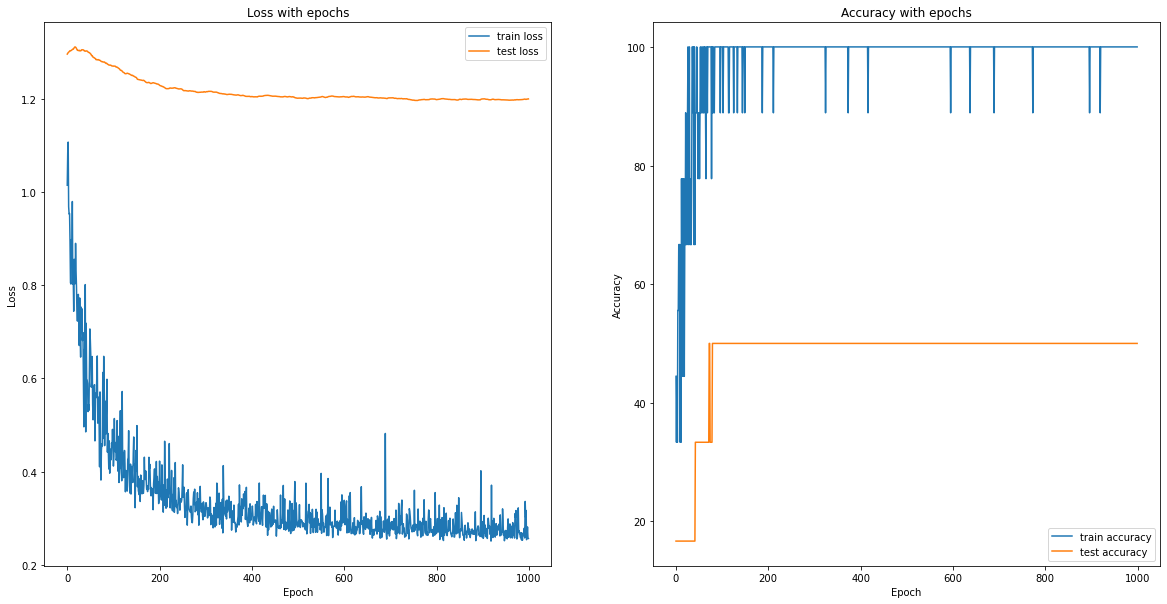

In [32]:
#Plotting of the loss
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(x_plot, train_loss, label = 'train loss')
ax[0].plot(x_plot, valid_loss, label = 'test loss')
ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(x_plot, train_accuracy, label = 'train accuracy')
ax[1].plot(x_plot, valid_accuracy, label = 'test accuracy')
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [51]:
print(model.DGCNLayer1.W[0])
print(model.DGCNLayer1.W[1])

tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)


In [21]:
def train_model(model, num_epochs, train_loader, test_loader, optimizer, loss_function, alpha):

    #training of the model
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []

    for epoch in range(num_epochs):

        ############################
        # Train
        ############################

        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()        # Put the network into training mode

        for i, (signal, label_) in enumerate(train_loader):

            optimizer.zero_grad()     # Clear off the gradients from any past operation
            outputs = model(signal)      # Do the forward pass
            loss = criterion(outputs, label_) # Calculate the loss
            iter_loss += loss.item() # Accumulate the loss

            #L1-Regularization
            l1_norm = sum(abs(p).sum() for p in model.parameters())
            loss = loss + alpha*l1_norm
            loss.backward()           # Calculate the gradients with help of back propagation
           #print('W')
           #print(model.GCNLayer1.W)
           #print(model.GCNLayer1.W.grad)
           #print('theta')
           #print(model.GCNLayer1.theta)
           #print(model.GCNLayer1.theta.grad)
            optimizer.step()          # Adjust the parameters based on the gradients


            # Record the correct predictions for training data 
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()
            iterations += 1

        # Record the training loss
        train_loss.append(iter_loss / iterations)
        # Record the training accuracy
        train_accuracy.append((100 * correct / float(len(train_dataset))))


        ############################
        # Test
        ############################

        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()                    # Put the network into evaluate mode

        for i, (signal, label_) in enumerate(test_loader):

            outputs = model(signal)      # Do the forward pass
            loss += criterion(outputs, label_).item() # Calculate the loss

            # Record the correct predictions for training data
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()

            iterations += 1

        # Record the validation loss
        valid_loss.append(loss / iterations)
        # Record the validation accuracy
        correct_scalar = np.array([correct.clone()])[0]
        valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy

## Time of execution

In [ ]:
import time

time_exec = np.zeros(10)

num_epochs = 1000
learning_rate = 0.001
alpha = 1e-7

exp_time_train_loss = []
exp_time_test_loss = []
exp_time_train_acc = []
exp_time_test_acc = []

K = 12

for k in range(10):
    
    W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

    model = DGCN_Poly(W_, K, 62*265, 50, 3).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 
    
    t1 = time.time()

    train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                                train_loader, test_loader, optimizer, 
                                                                         criterion, alpha)
    
    t2 = time.time()
    time_exec[k] = t2 - t1
    
    exp_time_train_loss.append(train_loss)
    exp_time_test_loss.append(valid_loss)
    exp_time_train_acc.append(train_accuracy)
    exp_time_test_acc.append(valid_accuracy)
    
print(np.mean(time_exec))

In [ ]:
exp_time_train_loss = np.array(exp_time_train_loss)
exp_time_test_loss = np.array(exp_time_test_loss)
exp_time_train_acc = np.array(exp_time_train_acc)
exp_time_test_acc = np.array(exp_time_test_acc)

mean_exp_time_train_loss = np.mean(exp_time_train_loss, axis = 0)
mean_exp_time_test_loss = np.mean(exp_time_test_loss, axis = 0)
mean_exp_time_train_acc = np.mean(exp_time_train_acc, axis = 0)
mean_exp_time_test_acc = np.mean(exp_time_test_acc, axis = 0)

x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(x_plot, mean_exp_time_train_loss, label = 'train loss')
ax[0].plot(x_plot, mean_exp_time_test_loss, label = 'test loss')
ax[1].plot(x_plot, mean_exp_time_train_acc, label = 'train accuracy')
ax[1].plot(x_plot, mean_exp_time_test_acc, label = 'test accuracy')

ax[0].set_title('Loss with epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title('Accuracy with epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

## Final Tabel

In [22]:
#matrix we will work with
W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

K = 9
    
#hyperparameters, loss functions and optimizer

learning_rate = 0.0001
alpha = 1e-7 #regularization parameter
num_epochs = 1000

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

In [23]:
W_de = W
print(W_de.shape)

W_dasm = torch.zeros(5, 27, 27)
for freq in range(5):
    W_dasm[freq, :, :] = W_de[0, :27, :27] #we take 0 because it's all the same for every frequencies
print(W_dasm.shape)

#initialization for DCAU
W_dcau = torch.zeros(5, 23, 23)
for freq in range(5):
    W_dcau[freq, :, :] = W_de[0, :23, :23] #we take 0 because it's all the same for every frequencies
print(W_dcau.shape)

#intialization for ASM 
W_asm = torch.zeros(5, 54, 54)
for freq in range(5):
    W_asm[freq, :, :] = W_de[0, :54, :54] #we take 0 because it's all the same for every frequencies
print(W_asm.shape)

def choose_W(feature, W_de, W_dasm, W_dcau, W_asm):
    if feature == 'de' or feature == 'psd':
        return W_de
    if feature == 'dasm' or feature == 'rasm':
        return W_dcam
    if feature == 'dcau':
        return W_dcau
    if feature == 'asm':
        return W_asm
    


torch.Size([5, 62, 62])
torch.Size([5, 27, 27])
torch.Size([5, 23, 23])
torch.Size([5, 54, 54])


In [24]:
path = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
l, label_ = import_matfiles(path)
labels = loadmat(path + '\\' + label_)['label']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

smoothing_method = 'movingAve'
batch_size = 1
learning_rate = 0.0001
alpha = 1e-7
K = 9
num_epochs = 1000

label.mat


In [26]:
def feature_model_adaptator(feature, device):
    if feature == 'de' or feature == 'psd':
        model = DGCN_ChebNormMod(W_, K, 62*265, 50, 3).to(device)
    elif feature == 'dasm' or feature == 'rasm':
        model = DGCN_ChebNormMod(W_, K, 27*265, 50, 3).to(device)
    elif feature == 'dcau':
        model = DGCN_ChebNormMod(W_, K, 23*265, 50, 3).to(device)
    elif feature == 'asm':
        model = DGCN_ChebNormMod(W_, K, 54*265, 50, 3).to(device)
    else :
        raise TypeError("Select a good feature: de, psd, dasm, rasm, dcau, asm")
    return model

In [3]:
final_test_acc = []

t1 = time.time()
for feature in ['de', 'psd', 'dasm', 'rasm', 'dcau', 'asm']:
    
    final_test_feature_acc = []
    signals = feature
    
    for freq in range(4):
        
        glob_test_acc = []
        use_freq = freq

        for sub in range(1, 16):
            subject_number = sub
            
            
            for exp in range(3):
                
                
                experiment_number = exp
                dataset = SignalDataset(path, signals, subject_number, experiment_number, 
                                        labels, smoothing_method, freq = use_freq)
                train_dataset, test_dataset = random_split(dataset, [9, 6])
                batch_size = 1
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
                test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
                #matrix we will work with
                W = choose_W(feature, W_de, W_dasm, W_dcau, W_asm)
                W_ = W[use_freq].type(torch.float32).clone().detach().requires_grad_(True) #work with the first brain frequency

                #model
                model = feature_model_adaptator(feature, device)

                #oss functions and optimizer

                criterion = nn.CrossEntropyLoss()

                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

                train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, num_epochs, 
                                                                        train_loader, test_loader, optimizer, 
                                                                                 criterion, alpha)

                glob_test_acc.append(valid_accuracy)
                
        final_test_feature_acc.append(glob_test_acc)
        
    final_test_acc.append(final_test_feature_acc)
        
t2 = time.time()
print(t1-t2)

NameError: name 'time' is not defined